<a href="https://colab.research.google.com/github/Le4o/topicos-avancados-ic/blob/main/Atividade_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Séries Temporais
#### Exercício da matéria de Tópicos Avançados em Inteligência Computacional

Grupo:
- João Victor de Sledz Bulhões
- Leonardo de Andrade Santana
- Lis da Silva Azevedo

### Definição do Exercício

A atividade é **prever para as próximas 6h o valor da concentração de PM2.5**.
Utilize os conceitos aprendidos até aqui, **testando diferentes modelos de IA** e **diferentes abordagens para conseguir prever com o melhor desempenho o valor das próximas 6h da concentração de PM2.5 para uma série histórica de sua escolha.**  
1.   Escolha uma estação de monitoramento de uma das cidades com que irá trabalhar; 
2.   Faça uma análise exploratória dos dados, avaliando estatisticamente e graficamente como os dados se comportam;
3.   Explore as técnicas **MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM**, utilizando a camada **TimeDistributed**;
4.   Escolha, com base na avaliação do **loss** e das métricas **MAE, MSE, NMSE, r, R2 e Fac2** qual foi o melhor modelo (e apresente justificando a resposta);
5.   Use o ano de 2015 somente para fins de teste.

### Observação: 
*   *Apresente os resultados de forma lógica, organizada e que seja reprodutível pelo professor (linhas comentadas);*
*   *Apresentação de métricas, gráficos, são essenciais para entendimento dos modelos e justificativas.*

### Opcionais:

*   Pode-se utilizar as informações meteorológicas para melhorar a qualidade do modelo final;
*   Interessante, mas não obrigatório, a utilização de wavelets para feature augmentation.


### Links:

* [Código para o colab (referência)](https://colab.research.google.com/drive/1b5177FoO4JsyOKN8dmbmTjvPi32b95of?usp=sharing) 

* [Link da base de dados da atividade](https://archive.ics.uci.edu/ml/datasets/PM2.5+Data+of+Five+Chinese+Cities)

* [Link para download da base de dados da atividade](https://drive.google.com/file/d/19FsUZXhakjteNoC3nsqUe2aTq3s7GoQI/view?usp=drive_web&authuser=1)


#Bibliotecas

In [31]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from zipfile import ZipFile 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv1D, MaxPooling1D, MaxPooling3D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from keras.layers import TimeDistributed


In [32]:
!pip install tensorflow_addons keras_metrics

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [33]:
!pip install -U scikit-fuzzy

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
The folder you are executing pip from can no longer be found.


In [34]:
from skfuzzy.image.metrics import nmse
import keras_metrics
from tensorflow.keras.metrics import Precision, Recall
from tensorflow_addons.metrics import F1Score

import sklearn.metrics
from sklearn.metrics import r2_score
from sklearn.feature_selection import r_regression
#MAE, MSE, NMSE, r, R2 e Fac2

# Funções de uso geral

In [73]:
perda = 'mae'
metrica = ['mse']

In [79]:
def plot_bar_graph(model_name, values, label, ord):
    plt.subplot(ord[0], ord[1], ord[2])
    plt.bar(model_name, values, color ='blue', width = 0.1)
    plt.xlabel("Models")
    plt.ylabel(label)
    plt.title("Comparing {} by models".format(label))

In [35]:
def print_metrics(test_results):
  print(f'Loss: {test_results[0]}\nAccuracy: {test_results[1]}\nPrecision: {test_results[2]}\nRecall: {test_results[3]}\nF1 Score: {test_results[4]}\nSpecificity: {test_results[5]}')


In [108]:
#MAE, MSE, NMSE, r, R2 e Fac2

def plot_history_predictions(history, Xtrain, Ytrain, Xtest, Ytest, scaler, model, title, xlabel, ylabel, lookback):
    # Resumo do historico de loss
    plt.figure(figsize=(20, 5))
    plt.plot(history.history['loss'], color='blue')
    plt.plot(history.history['val_loss'], color='red')
    plt.title('Model loss', fontsize=20)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
    plt.show()

    # faz as predições
    trainPredict = model.predict(Xtrain)
    testPredict = model.predict(Xtest)

    # inverte as predições
    if(len(trainPredict.shape)==3):
        trainPredict=trainPredict[:,-1,:]
        testPredict=testPredict[:,-1,:]
    trainPredict = scaler.inverse_transform(trainPredict)
    trainYTrue = scaler.inverse_transform(Ytrain)
    testPredict = scaler.inverse_transform(testPredict)
    testYTrue = scaler.inverse_transform(Ytest)

    # calcula o root mean squared error
    trainScoreRMSE = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
    print('Treinamento: %.2f RMSE' % (trainScoreRMSE))
    testScoreRMSE = math.sqrt(mean_squared_error(testYTrue, testPredict))
    print('Teste: %.2f RMSE' % (testScoreRMSE))
    
    # Calcula NMSE
    # print('\n Calcula NMSE')
    # trainScoreNMSE = nmse(trainYTrue, trainPredict)
    # print('Treinamento: %.2f' % (trainScoreNMSE))
    # testScoreNMSE = nmse(testYTrue, testPredict)
    # print('Teste: %.2f' % (testScoreNMSE))
    
    #Calcula R Regression
    print('\n Calcula R Regression')
    trainScoreR = r_regression(trainYTrue, trainPredict)
    print('Treinamento: %.2f' % (trainScoreR))
    testScoreR = r_regression(testYTrue, testPredict)
    print('Teste: %.2f' % (testScoreR))

    # Calcula r2
    print('\n Calcula R2')
    trainScoreR2 = sklearn.metrics.r2_score(trainYTrue, trainPredict)
    print('Treinamento: %.2f' % (trainScoreR2))
    testScoreR2 = sklearn.metrics.r2_score(testYTrue, testPredict)
    print('Teste: %.2f' % (testScoreR2))

    # Calcula Fac2
    # print('\n Calcula Fac2')
    # trainScoreFac2 = sklearn.metrics.r2_score(trainYTrue, trainPredict)
    # print('Treinamento: %.2f' % (trainScoreFac2))
    # testScoreFac2 = sklearn.metrics.r2_score(testYTrue, testPredict)
    # print('Teste: %.2f' % (testScoreFac2))

    plt.figure(figsize=[10,5])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()
    plt.plot(range(len(data)),data,'k.')
    plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
    plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
    plt.legend(['Original','Treinamento','Teste']);

    #return [testScoreNMSE, testScoreR, testScoreR2]
    return [0, testScoreR, testScoreR2]
    

In [38]:
#MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM
# allMetrics = ["MLP":{
#     MAE: 0,
# }]

#metricsDF = np.array([['','MLP', 'RNN simples', 'LSTM', 'GRU', 'CNN1D', 'FCN+LSTM', 'Conv2DLSTM'],
             
#MAE, MSE, NMSE, r, R2 e Fac2

# Carregando os dados

Para garantir que nossos resultados sejam reprodutíveis, vamos fixar a semente de aleatorização (random seed) 

In [39]:
# fixa random seed para garantir reprodutibilidade
np.random.seed(0)

In [40]:
# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)
# %cd /content/drive/My Drive/

In [41]:
# Carrega o dataset
df = pd.read_csv('/content/drive/MyDrive/Disciplinas/2021.2/Tópicos_Intel_Comp/Séries_Temporais/FiveCitiesPM/Shanghai.csv', engine='python', skipfooter=3)
#df = pd.read_csv('/content/drive/MyDrive/Datasets/FiveCitiesPM/Shanghai.csv', engine='python', skipfooter=3)
df = df.iloc[17443:, :]
df.interpolate(inplace=True)
df_posts = df[['PM_US Post']] 
data = df_posts.values
data = data.astype('float32')
# data = df_posts.values
# data = df_posts.astype('float32')
print('Quantidade de dados no arquivo:', len(data))

Quantidade de dados no arquivo: 35138


In [42]:
# Separando dados de teste e treino
# Ano de 2015 será utilizado para o treino
train = df[df.year != 2015]
test = df[df.year == 2015]

print(len(train))
print(len(test))

# Selecionando coluna de série PM_US Post
train = train[['PM_US Post']]
test = test[['PM_US Post']]

26381
8757


In [43]:
# Primeira posição válida
print (train.loc[train["PM_US Post"].first_valid_index()])

PM_US Post    41.0
Name: 17443, dtype: float64


In [44]:
# Removendo valores NaN da série
# train = train.iloc[17443:, :]

# Criando numpy array
train = train.values
test = test.values

data = df_posts.values

data = data.astype('float32')
train = train.astype('float32')
test = test.astype('float32')

## Visualizando os dados

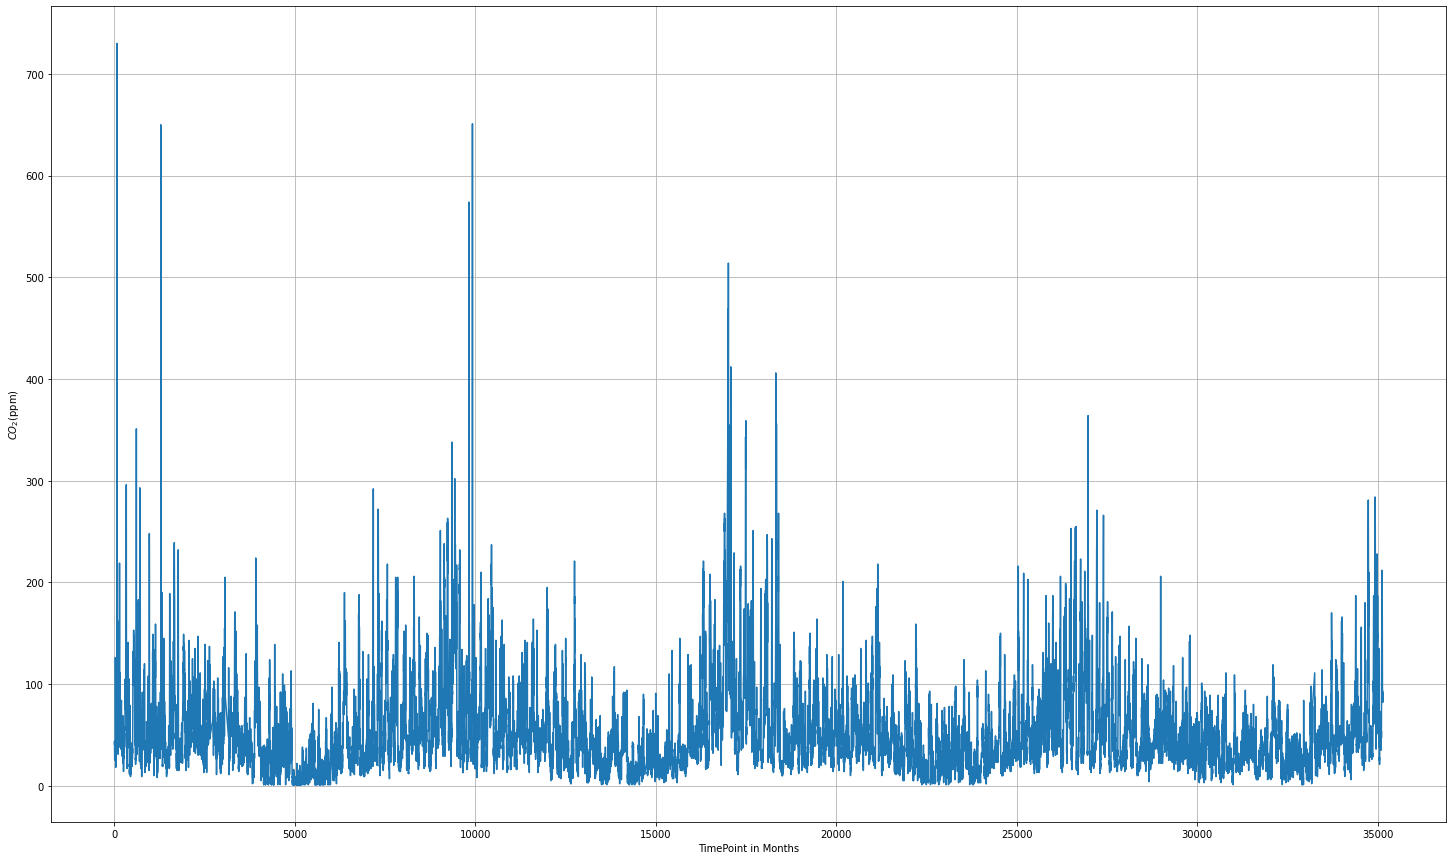

In [45]:
plt.figure(figsize=[25, 15])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);

Em séries temporais, a sequência dos dados é importante. Para criar a divisão entre treinamento e teste, utilizaremos a primeira parte da série para treinamento, e a última para o teste. 


# Tratamento de Dados

In [46]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
data_train_fit = scaler.fit_transform(data)
norm_train = scaler.transform(train)
norm_test = scaler.transform(test)

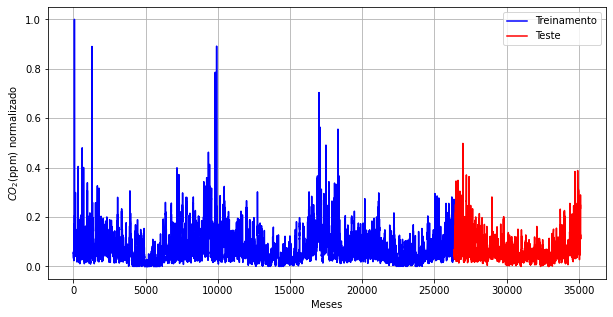

In [47]:
plt.figure(figsize=[10,5])
plt.xlabel('Meses')
plt.ylabel('$CO_2$(ppm) normalizado')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Treinamento','Teste'])

In [48]:
def split_X_y(data, look_back = 1):
    X, y = [], []
    for i in range(len(data)-look_back):
        val = data[i:i+look_back,0]
        X.append(val)
        y.append(data[i+look_back:i+look_back+1,0])
    return np.array(X), np.array(y)

In [49]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 1 # olha somente para a amostra anterior para prever a próxima amostra


A RNN simples espera que os dados de entrada (X) sejam fornecidos na forma de: [sample, time steps, features].

Atualmente, os dados estão no formato: [samples, features], e estamos modelando o problema como um timestep para cada amostra. Usando numpy.reshape () da seguinte forma fazemos a devida transformação:

In [50]:
# # reshape a entrada para [samples, time steps, features]
def reshape_train_test(look_back, split_size):
    trainX_whole, trainY_whole = split_X_y(norm_train, look_back)
    testX, testY = split_X_y(norm_test, look_back)
    trainX_whole = np.reshape(trainX_whole, (trainX_whole.shape[0], look_back, data.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], look_back, data.shape[1]))

    # cria o dataset de validação
    trainX, valX, trainY, valY = train_test_split(trainX_whole, trainY_whole, test_size=split_size)
    return trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY

In [51]:
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

print('Shape de x_train', trainX.shape)
print('Shape de x_val', valX.shape)
print('Shape de x_test', testX.shape)

print('Shape de y_train', trainY.shape)
print('Shape de y_val', valY.shape)
print('Shape de y_test', testY.shape)

trainX

Shape de x_train (7914, 1, 1)
Shape de x_val (18466, 1, 1)
Shape de x_test (8756, 1, 1)
Shape de y_train (7914, 1)
Shape de y_val (18466, 1)
Shape de y_test (8756, 1)


array([[[0.05898491]],

       [[0.1303155 ]],

       [[0.06584362]],

       ...,

       [[0.08367627]],

       [[0.15500686]],

       [[0.08864232]]], dtype=float32)

Vamos agora projetar e ajustar nossa RNN simples.

A rede tem uma camada visível com 1 entrada, uma camada oculta com 4 blocos recorrentes ou neurônios e uma camada de saída que faz uma previsão de valor único. A função de ativação sigmóide padrão é usada para os blocos recorrentes. A rede é treinada por 20 épocas e um tamanho de lote de 1 é usado.

# Rede RNN simples

In [74]:
# cria e ajusta a RNN simples 
K.clear_session()
modelRNN = Sequential()
modelRNN.add(SimpleRNN(4, activation='linear', input_shape=(look_back, data.shape[1])))
modelRNN.add(Dense(1))
# model.add(TimeDistributed(Dense(1)))

modelRNN.compile(loss=[perda], metrics=metrica, optimizer='adam')

history = modelRNN.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/20
7914/7914 [==============================] - 33s 4ms/step - loss: 0.0119 - mse: 4.6935e-04 - val_loss: 0.0104 - val_mse: 4.2018e-04
Epoch 2/20
7914/7914 [==============================] - 32s 4ms/step - loss: 0.0104 - mse: 3.5337e-04 - val_loss: 0.0103 - val_mse: 4.2949e-04
Epoch 3/20
7914/7914 [==============================] - 30s 4ms/step - loss: 0.0105 - mse: 3.6257e-04 - val_loss: 0.0112 - val_mse: 4.4785e-04
Epoch 4/20
7914/7914 [==============================] - 30s 4ms/step - loss: 0.0103 - mse: 3.5958e-04 - val_loss: 0.0110 - val_mse: 4.4509e-04
Epoch 5/20
7914/7914 [==============================] - 32s 4ms/step - loss: 0.0104 - mse: 3.6279e-04 - val_loss: 0.0108 - val_mse: 4.3190e-04
Epoch 6/20
7914/7914 [==============================] - 30s 4ms/step - loss: 0.0103 - mse: 3.5152e-04 - val_loss: 0.0117 - val_mse: 4.5913e-04
Epoch 7/20
7914/7914 [==============================] - 32s 4ms/step - loss: 0.0104 - mse: 3.6949e-04 - val_loss: 0.0107 - val_mse: 4.3563e-04

In [75]:
results_rnn = modelRNN.evaluate(trainX, trainY, verbose=1)
print(results_rnn)

248/248 [==============================] - 1s 2ms/step - loss: 0.0099 - mse: 3.4094e-04
[0.009857634082436562, 0.00034094086731784046]


Vamos agora definir uma função para fazer as previsões e plotar. 
Uma vez que o modelo estiver ajustado, podemos estimar o desempenho do modelo nos conjuntos de dados de treinamento e teste.

Observe que devemos inverter (desnormalizar) as previsões antes de calcular a acurácia para garantir que o desempenho seja comparado nas mesmas unidades que os dados originais (ppm por mês).

As previsões foram geradas usando o modelo para o conjunto de dados de treinamento e de teste. Também podemos visualizar os resultados para ter uma indicação de como o modelo funciona.

Ao plotar os dados, devemos deslocar as previsões pelo look_back no tempo para alinhar no eixo x com o conjunto de dados original. Os dados são apresentados com o conjunto de dados original como pontos pretos, as previsões para o conjunto de dados de treinamento em azul e as previsões no conjunto de dados de teste em vermelho.

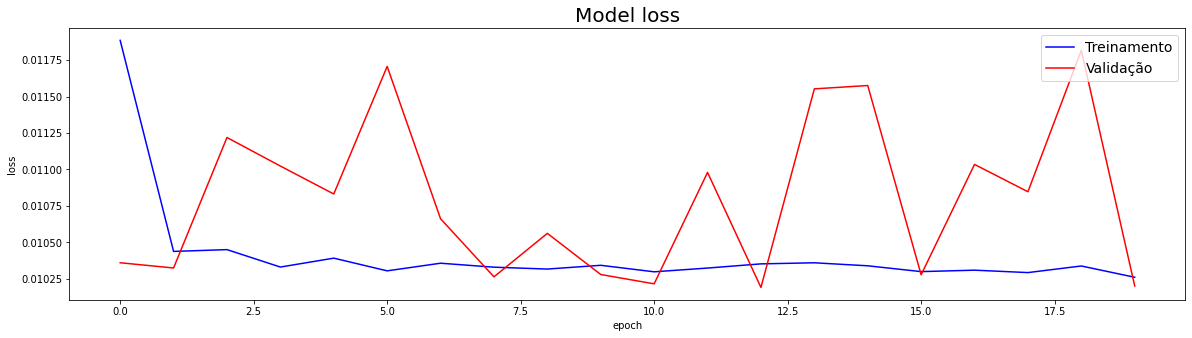

Treinamento: 14.57 RMSE
Teste: 10.04 RMSE

 Calcula NMSE
Treinamento: 11.16
Teste: 6.56

 Calcula R Regression
Treinamento: 0.94
Teste: 0.97

 Calcula R2
Treinamento: 0.89
Teste: 0.93


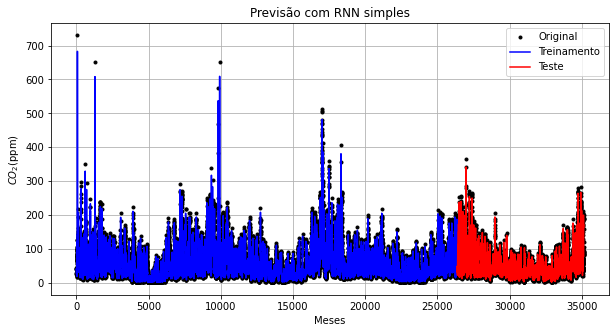

In [76]:
RNNMetrics = plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, model, 
                         'Previsão com RNN simples', 'Meses', '$CO_2$(ppm)', look_back)

# Rede LSTM

Vamos agora projetar e ajustar nossa rede LSTM.


In [59]:
# cria e ajusta a rede LSTM 
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back, data.shape[1])))
modelLSTM.add(Dense(1, activation='linear'))

#MAE, MSE, NMSE, r, R2 e Fac2
#MLP, RNN simples, LSTM, GRU, CNN1D, FCN+LSTM e Conv2DLSTM


modelLSTM.compile(loss=[perda], metrics=metrica, optimizer='adam')

history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/20
7914/7914 [==============================] - 32s 4ms/step - loss: 0.0127 - mse: 6.2457e-04 - val_loss: 0.0106 - val_mse: 5.0595e-04
Epoch 2/20
7914/7914 [==============================] - 33s 4ms/step - loss: 0.0105 - mse: 4.1738e-04 - val_loss: 0.0103 - val_mse: 4.6004e-04
Epoch 3/20
7914/7914 [==============================] - 33s 4ms/step - loss: 0.0104 - mse: 3.7950e-04 - val_loss: 0.0114 - val_mse: 4.6502e-04
Epoch 4/20
7914/7914 [==============================] - 33s 4ms/step - loss: 0.0104 - mse: 3.7095e-04 - val_loss: 0.0103 - val_mse: 4.3117e-04
Epoch 5/20
7914/7914 [==============================] - 32s 4ms/step - loss: 0.0104 - mse: 3.6200e-04 - val_loss: 0.0110 - val_mse: 4.4040e-04
Epoch 6/20
7914/7914 [==============================] - 31s 4ms/step - loss: 0.0103 - mse: 3.5857e-04 - val_loss: 0.0103 - val_mse: 4.1937e-04
Epoch 7/20
7914/7914 [==============================] - 33s 4ms/step - loss: 0.0104 - mse: 3.6134e-04 - val_loss: 0.0104 - val_mse: 4.2965e-04

In [61]:
results_lstm = modelLSTM.evaluate(trainX, trainY, verbose=1)
print(results_lstm)

248/248 [==============================] - 40s 162ms/step - loss: 0.0106 - mse: 3.6009e-04
[0.010600676760077477, 0.00036008923780173063]


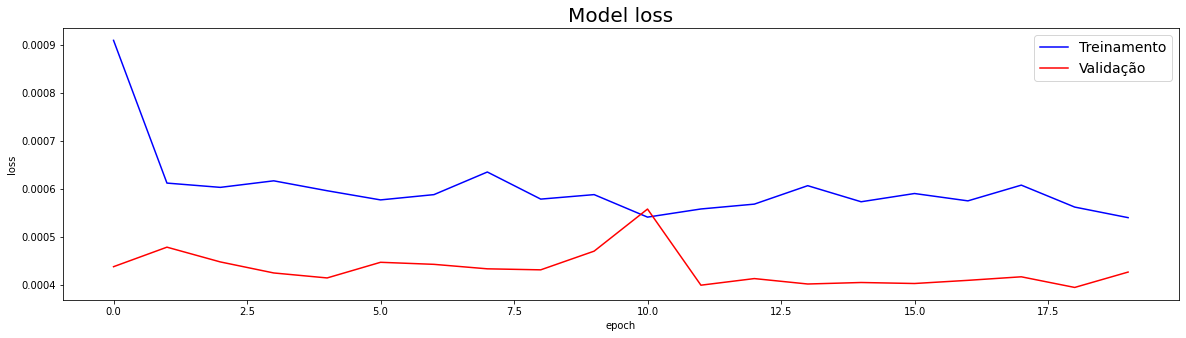

Treinamento: 14.80 RMSE
Teste: 10.29 RMSE

 Calcula R Regression
Treinamento: 0.94
Teste: 0.97

 Calcula R2
Treinamento: 0.88
Teste: 0.93


0

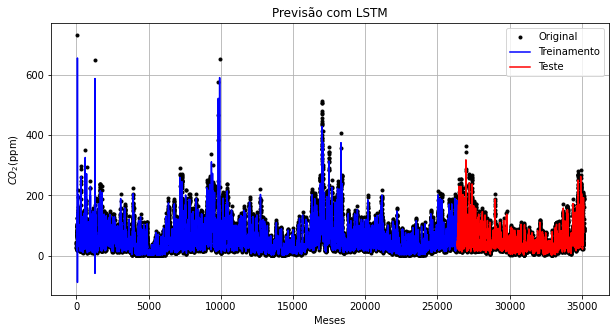

In [109]:
LSTMMetrics = plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM,'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)

LSTMMetrics[0]



### Problema 3

Melhore os resultados acima tentando o seguinte:
- Aumentar o número de épocas
- Aumentar o valor look_back
- Modificar a arquitetura
- Outros...

Como exemplo, use look_back de 5, aumente o tamanho do dataset de treinamento, aumente o número de épocas e adicione uma camada de dropout


In [94]:
look_back = 5 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)


In [95]:
del modelLSTM
modelLSTM = Sequential()
modelLSTM.add(LSTM(4, activation='linear', input_shape=(look_back,data.shape[1])))
modelLSTM.add(Dropout(0.2))
modelLSTM.add(Dense(1))
modelLSTM.compile(loss='mean_squared_error', metrics=metrica, optimizer='adam')
history = modelLSTM.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))


Epoch 1/20
7912/7912 [==============================] - 40s 5ms/step - loss: 9.0938e-04 - mse: 9.0938e-04 - val_loss: 5.7881e-04 - val_mse: 5.7881e-04
Epoch 2/20
7912/7912 [==============================] - 58s 7ms/step - loss: 5.9261e-04 - mse: 5.9261e-04 - val_loss: 4.8403e-04 - val_mse: 4.8403e-04
Epoch 3/20
7912/7912 [==============================] - 58s 7ms/step - loss: 5.2602e-04 - mse: 5.2602e-04 - val_loss: 5.0281e-04 - val_mse: 5.0281e-04
Epoch 4/20
7912/7912 [==============================] - 39s 5ms/step - loss: 5.0583e-04 - mse: 5.0583e-04 - val_loss: 6.2593e-04 - val_mse: 6.2593e-04
Epoch 5/20
7912/7912 [==============================] - 58s 7ms/step - loss: 4.6287e-04 - mse: 4.6287e-04 - val_loss: 4.6391e-04 - val_mse: 4.6391e-04
Epoch 6/20
7912/7912 [==============================] - 39s 5ms/step - loss: 5.2064e-04 - mse: 5.2064e-04 - val_loss: 4.8132e-04 - val_mse: 4.8132e-04
Epoch 7/20
7912/7912 [==============================] - 58s 7ms/step - loss: 4.7366e-04 - mse:

In [96]:
results_lstm2 = modelLSTM.evaluate(trainX, trainY, verbose=1)
print(results_lstm)

248/248 [==============================] - 1s 2ms/step - loss: 2.7220e-04 - mse: 2.7220e-04
[0.010600676760077477, 0.00036008923780173063]


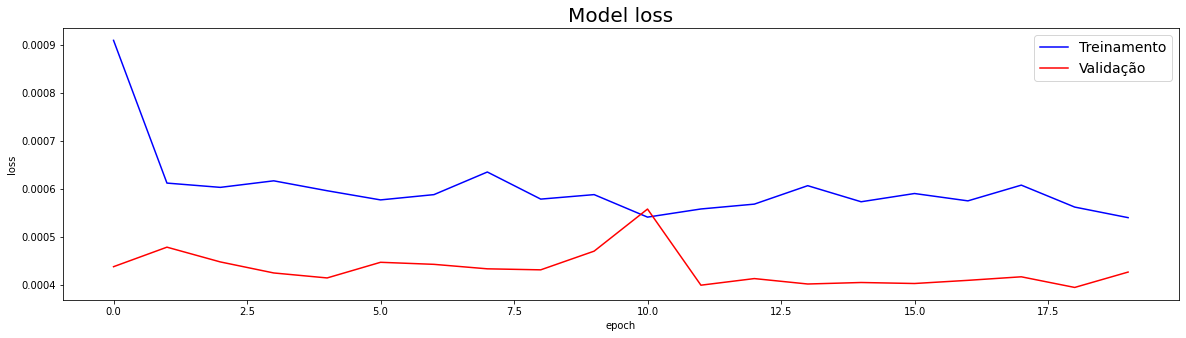

Treinamento: 14.80 RMSE
Teste: 10.29 RMSE

 Calcula R Regression
Treinamento: 0.94
Teste: 0.97

 Calcula R2
Treinamento: 0.88
Teste: 0.93


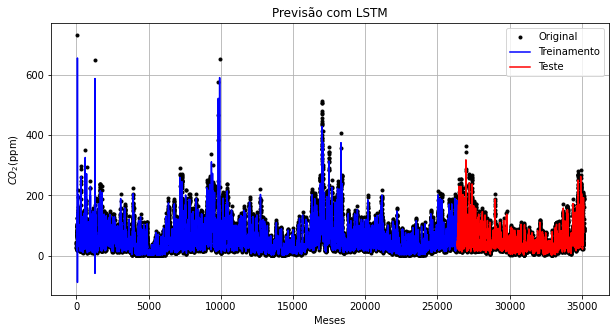

In [110]:
LSTMMetrics2 = plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelLSTM, 
                         'Previsão com LSTM', 'Meses', '$CO_2$(ppm)', look_back)


# Rede GRU

Utilizar outro modelo, a GRU


In [100]:
# reshape em X contendo os dados para as amostras t-i ... t-2 t-1 e Y contendo as amostras t
look_back = 5 # olha somente para as amostras anteriores para prever a próxima amostra
trainX_whole, trainX, valX, testX, trainY_whole, trainY, valY, testY = reshape_train_test(look_back, 0.7)

In [101]:
modelGRU = Sequential()
modelGRU.add(GRU(4, input_shape=(look_back, data.shape[1])))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(1, activation='linear'))
modelGRU.compile(loss='mean_squared_error',metrics=metrica, optimizer='adam')
history = modelGRU.fit(trainX, 
                    trainY, 
                    epochs=20, 
                    batch_size=1, 
                    verbose=1, 
                    validation_data=(valX, valY))



Epoch 1/20
7912/7912 [==============================] - 41s 5ms/step - loss: 9.0910e-04 - mse: 9.0910e-04 - val_loss: 4.3845e-04 - val_mse: 4.3845e-04
Epoch 2/20
7912/7912 [==============================] - 59s 7ms/step - loss: 6.1230e-04 - mse: 6.1230e-04 - val_loss: 4.7905e-04 - val_mse: 4.7905e-04
Epoch 3/20
7912/7912 [==============================] - 59s 7ms/step - loss: 6.0340e-04 - mse: 6.0340e-04 - val_loss: 4.4834e-04 - val_mse: 4.4834e-04
Epoch 4/20
7912/7912 [==============================] - 39s 5ms/step - loss: 6.1700e-04 - mse: 6.1700e-04 - val_loss: 4.2541e-04 - val_mse: 4.2541e-04
Epoch 5/20
7912/7912 [==============================] - 58s 7ms/step - loss: 5.9640e-04 - mse: 5.9640e-04 - val_loss: 4.1505e-04 - val_mse: 4.1505e-04
Epoch 6/20
7912/7912 [==============================] - 39s 5ms/step - loss: 5.7732e-04 - mse: 5.7732e-04 - val_loss: 4.4760e-04 - val_mse: 4.4760e-04
Epoch 7/20
7912/7912 [==============================] - 38s 5ms/step - loss: 5.8830e-04 - mse:

In [102]:
results_gru = modelLSTM.evaluate(trainX, trainY, verbose=1)
print(results_gru)

248/248 [==============================] - 1s 2ms/step - loss: 3.8552e-04 - mse: 3.8552e-04
[0.00038552319165319204, 0.00038552319165319204]


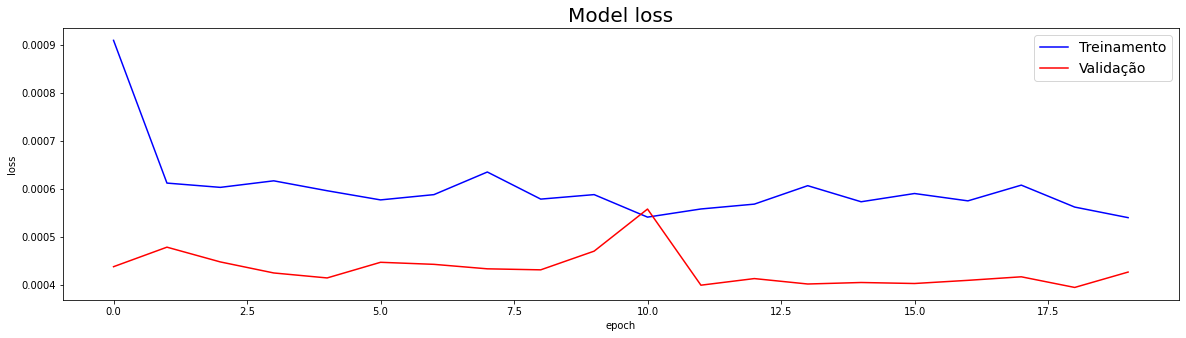

Treinamento: 14.95 RMSE
Teste: 11.04 RMSE

 Calcula R Regression
Treinamento: 0.95
Teste: 0.97

 Calcula R2
Treinamento: 0.88
Teste: 0.92


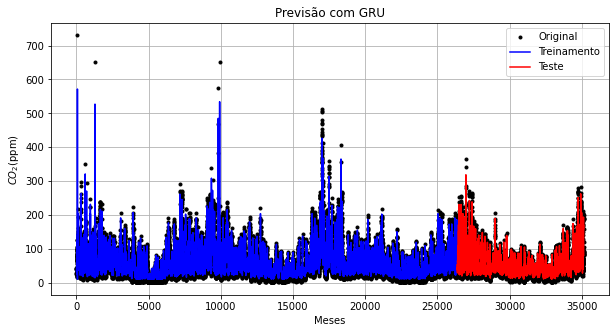

In [111]:
GRUMetrics = plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelGRU, 
                         'Previsão com GRU', 'Meses', '$CO_2$(ppm)', look_back)


#Rede CNN1D

Utilizar outro modelo, a CNN1D


In [112]:
modelCNN1D = Sequential()
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1D.add(Conv1D(filters=64, kernel_size=1, activation='tanh'))
modelCNN1D.add(MaxPooling1D(pool_size=1))
modelCNN1D.add(Dropout(0.2))
modelCNN1D.add(Flatten())
modelCNN1D.add(Dense(10, activation='tanh'))
modelCNN1D.add(Dense(1, activation='linear'))

modelCNN1D.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             128       
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 64)             4160      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 64)            0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 5, 64)             0         
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                3210      
                                                      

In [113]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1D.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), batch_size=batch_size)

Epoch 1/20
248/248 [==============================] - 3s 8ms/step - loss: 0.0146 - mse: 6.6456e-04 - val_loss: 0.0110 - val_mse: 4.2405e-04
Epoch 2/20
248/248 [==============================] - 1s 6ms/step - loss: 0.0119 - mse: 4.3447e-04 - val_loss: 0.0102 - val_mse: 4.0751e-04
Epoch 3/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0118 - mse: 4.2305e-04 - val_loss: 0.0101 - val_mse: 4.1176e-04
Epoch 4/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0115 - mse: 4.0704e-04 - val_loss: 0.0104 - val_mse: 4.0728e-04
Epoch 5/20
248/248 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 4.1029e-04 - val_loss: 0.0114 - val_mse: 4.7726e-04
Epoch 6/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0115 - mse: 4.1583e-04 - val_loss: 0.0107 - val_mse: 4.4023e-04
Epoch 7/20
248/248 [==============================] - 1s 5ms/step - loss: 0.0117 - mse: 4.2166e-04 - val_loss: 0.0107 - val_mse: 4.1254e-04
Epoch 8/20
248/248 [

In [114]:
results_cnn1d = modelLSTM.evaluate(trainX, trainY, verbose=1)
print(results_cnn1d)

248/248 [==============================] - 1s 2ms/step - loss: 3.8552e-04 - mse: 3.8552e-04
[0.00038552319165319204, 0.00038552319165319204]


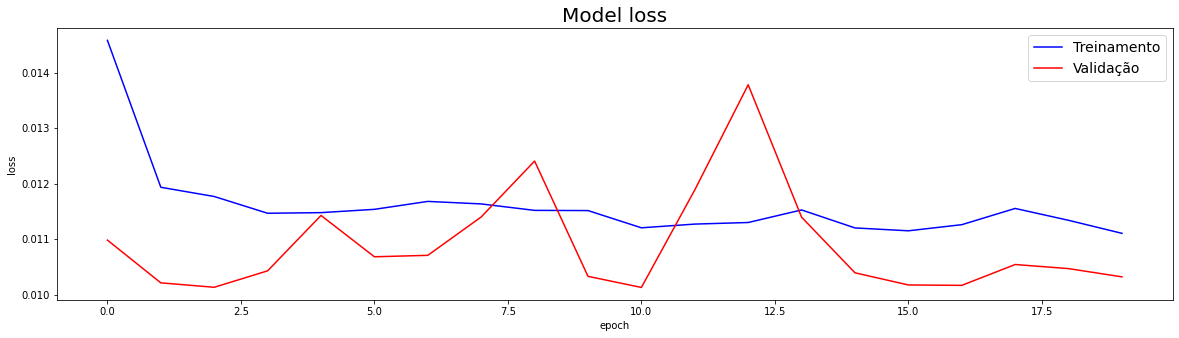

Treinamento: 14.42 RMSE
Teste: 9.96 RMSE

 Calcula R Regression
Treinamento: 0.94
Teste: 0.97

 Calcula R2
Treinamento: 0.89
Teste: 0.93


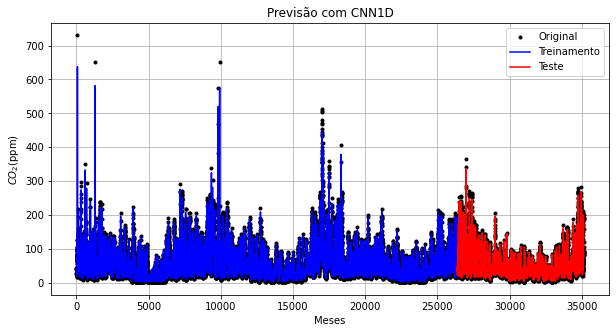

In [115]:
CNN1DMetrics = plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1D, 
                         'Previsão com CNN1D', 'Meses', '$CO_2$(ppm)', look_back)


# CNN1D - LSTM


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes.
Nesta primeira parte, vamos criar uma rede que combina operações de convolução, para depois enviar as principais características retornadas para uma camada LSTM. Esta abordagem é chamada muitas vezes de CNN-LSTM, FCN-LSTM ou FC-LSTM.


In [ ]:
modelCNN1DLSTM = Sequential()
modelCNN1DLSTM.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTM.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTM.add(LSTM(16, return_sequences=True))
modelCNN1DLSTM.add(Dropout(0.2))
modelCNN1DLSTM.add(Flatten())
modelCNN1DLSTM.add(Dense(10, activation='tanh'))
modelCNN1DLSTM.add(Dense(1, activation='linear'))

modelCNN1DLSTM.summary()

In [ ]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelCNN1DLSTM.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelCNN1DLSTM.fit(trainX, trainY, epochs=epochs, verbose=verbose, 
                             validation_data=(valX, valY), batch_size=batch_size)

In [ ]:
results_cnn1lstm = modelLSTM.evaluate(trainX, trainY, verbose=1)
#print(results_hybrid)

In [ ]:
CNN1DLSTMMetrics =plot_history_predictions(history, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTM, 
                         'Previsão com CNN+LSTM', 'Meses', '$CO_2$(ppm)', look_back)

# Conv2D - LSTM


Vamos utilizar uma abordagem híbrida que combina redes convolucionais e redes recorrentes: a Conv2DLSTM


In [116]:
trainX.shape


(7912, 5, 1)

In [117]:
trainX2D = trainX.reshape((trainX.shape[0], trainX.shape[1], 1, trainX.shape[2], 1))
valX2D = valX.reshape((valX.shape[0], valX.shape[1], 1, valX.shape[2], 1))
trainX2D.shape

(7912, 5, 1, 1, 1)

In [118]:
modelConvLSTM2D = Sequential()

modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True,
                           input_shape=(look_back, trainX2D.shape[2], trainX2D.shape[3], trainX2D.shape[4])))
modelConvLSTM2D.add(ConvLSTM2D(filters=128, kernel_size=(1,1), activation='tanh', return_sequences=True))
modelConvLSTM2D.add(MaxPooling3D(pool_size=(look_back,1,1)))
modelConvLSTM2D.add(Dropout(0.2))
modelConvLSTM2D.add(Flatten())
modelConvLSTM2D.add(Dense(10, activation='tanh'))
modelConvLSTM2D.add(Dense(1, activation='linear'))


In [119]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

modelConvLSTM2D.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

history = modelConvLSTM2D.fit(trainX2D, trainY, epochs=epochs, verbose=verbose, validation_data=(valX2D, valY), 
                              batch_size=batch_size)

Epoch 1/20
248/248 [==============================] - 14s 41ms/step - loss: 0.0189 - mse: 9.9566e-04 - val_loss: 0.0125 - val_mse: 4.6662e-04
Epoch 2/20
248/248 [==============================] - 10s 40ms/step - loss: 0.0128 - mse: 4.9923e-04 - val_loss: 0.0104 - val_mse: 3.7876e-04
Epoch 3/20
248/248 [==============================] - 10s 39ms/step - loss: 0.0120 - mse: 4.4800e-04 - val_loss: 0.0108 - val_mse: 3.6140e-04
Epoch 4/20
248/248 [==============================] - 10s 39ms/step - loss: 0.0116 - mse: 4.2359e-04 - val_loss: 0.0105 - val_mse: 3.4699e-04
Epoch 5/20
248/248 [==============================] - 10s 39ms/step - loss: 0.0114 - mse: 4.0530e-04 - val_loss: 0.0110 - val_mse: 3.7517e-04
Epoch 6/20
248/248 [==============================] - 10s 39ms/step - loss: 0.0116 - mse: 4.1720e-04 - val_loss: 0.0106 - val_mse: 3.6539e-04
Epoch 7/20
248/248 [==============================] - 10s 39ms/step - loss: 0.0114 - mse: 3.9701e-04 - val_loss: 0.0104 - val_mse: 3.5722e-04
Epoch 

In [120]:
results_lstm2d = modelLSTM.evaluate(trainX, trainY, verbose=1)
#print(results_hybrid)

248/248 [==============================] - 1s 2ms/step - loss: 3.8552e-04 - mse: 3.8552e-04


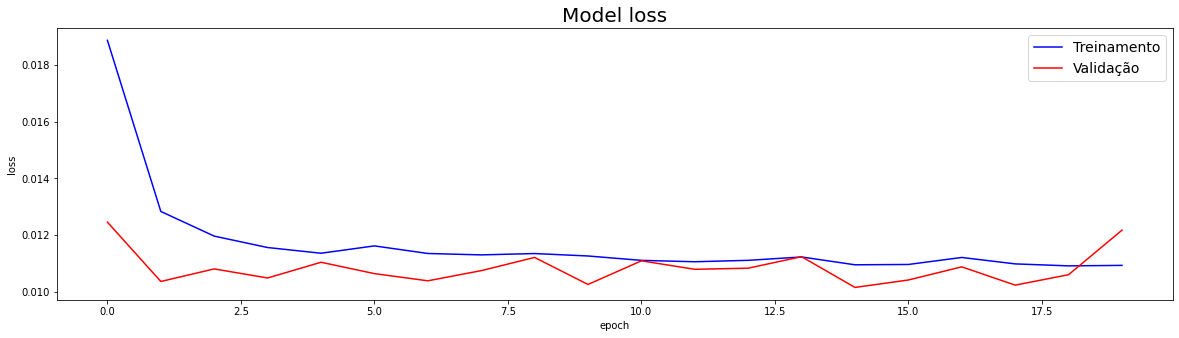

Treinamento: 14.74 RMSE
Teste: 11.11 RMSE

 Calcula R Regression
Treinamento: 0.95
Teste: 0.97

 Calcula R2
Treinamento: 0.88
Teste: 0.92


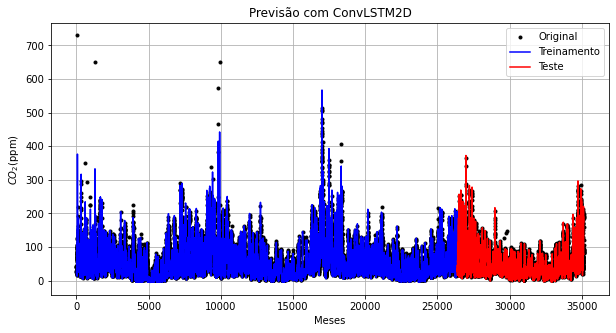

In [121]:
trainX2D_whole = trainX_whole.reshape((trainX_whole.shape[0], trainX_whole.shape[1], 1, trainX_whole.shape[2], 1))
testX2D = testX.reshape((testX.shape[0], testX.shape[1], 1, testX.shape[2], 1))


LSTM2DMetrics = plot_history_predictions(history, trainX2D_whole, trainY_whole, testX2D, testY, scaler, modelConvLSTM2D, 
                         'Previsão com ConvLSTM2D', 'Meses', '$CO_2$(ppm)', look_back)

# TimeDistributed


In [127]:
#Rede FCN+LSTM sem TimeDistributed
modelCNN1DLSTMSemTD = Sequential()
modelCNN1DLSTMSemTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMSemTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMSemTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMSemTD.add(Dense(10, activation='tanh'))
modelCNN1DLSTMSemTD.add(Dense(1, activation='linear'))

#Rede FCN+LSTM com TimeDistributed
modelCNN1DLSTMTD = Sequential()
modelCNN1DLSTMTD.add(Conv1D(filters=128, kernel_size=1, activation='tanh', input_shape=(look_back, data.shape[1])))
modelCNN1DLSTMTD.add(MaxPooling1D(pool_size=1))
modelCNN1DLSTMTD.add(LSTM(16, return_sequences=True))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(10, activation='tanh')))
modelCNN1DLSTMTD.add(TimeDistributed(Dense(1, activation='linear')))


In [128]:
tx = 0.001
verbose = 1
epochs = 20
batch_size = 32

perda = 'mae'
metrica = 'mse'

#treinando a rede sem TimeDistributed
modelCNN1DLSTMSemTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historySemTD = modelCNN1DLSTMSemTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
248/248 [==============================] - 4s 10ms/step - loss: 0.0208 - mse: 0.0012 - val_loss: 0.0173 - val_mse: 9.2518e-04
Epoch 2/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0181 - mse: 0.0010 - val_loss: 0.0170 - val_mse: 9.0433e-04
Epoch 3/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0178 - mse: 9.9469e-04 - val_loss: 0.0169 - val_mse: 8.7705e-04
Epoch 4/20
248/248 [==============================] - 2s 10ms/step - loss: 0.0179 - mse: 9.8662e-04 - val_loss: 0.0169 - val_mse: 8.6544e-04
Epoch 5/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0178 - mse: 9.6864e-04 - val_loss: 0.0173 - val_mse: 8.8456e-04
Epoch 6/20
248/248 [==============================] - 2s 10ms/step - loss: 0.0177 - mse: 9.6919e-04 - val_loss: 0.0169 - val_mse: 8.5081e-04
Epoch 7/20
248/248 [==============================] - 2s 10ms/step - loss: 0.0176 - mse: 9.5201e-04 - val_loss: 0.0172 - val_mse: 8.6531e-04
Epoch 8/20
248/248 [====

In [129]:
# treinando a rede com TimeDistributed
modelCNN1DLSTMTD.compile(loss=[perda], optimizer=tensorflow.keras.optimizers.Adam(lr = tx), metrics=[metrica])

historyTD = modelCNN1DLSTMTD.fit(trainX, trainY, epochs=epochs, verbose=verbose, validation_data=(valX, valY), 
                              batch_size=batch_size)


Epoch 1/20
248/248 [==============================] - 5s 12ms/step - loss: 0.0219 - mse: 0.0014 - val_loss: 0.0185 - val_mse: 9.7719e-04
Epoch 2/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0183 - mse: 0.0010 - val_loss: 0.0173 - val_mse: 9.3331e-04
Epoch 3/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0178 - mse: 9.9321e-04 - val_loss: 0.0170 - val_mse: 8.7598e-04
Epoch 4/20
248/248 [==============================] - 3s 10ms/step - loss: 0.0178 - mse: 9.8182e-04 - val_loss: 0.0171 - val_mse: 8.6711e-04
Epoch 5/20
248/248 [==============================] - 2s 10ms/step - loss: 0.0177 - mse: 9.6374e-04 - val_loss: 0.0169 - val_mse: 8.4715e-04
Epoch 6/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0178 - mse: 9.7114e-04 - val_loss: 0.0169 - val_mse: 8.4942e-04
Epoch 7/20
248/248 [==============================] - 2s 8ms/step - loss: 0.0176 - mse: 9.5861e-04 - val_loss: 0.0169 - val_mse: 8.5247e-04
Epoch 8/20
248/248 [=====

In [130]:
#vamos ver o shape retornado do predict da rede com e sem TimeDistributed
tsTD=modelCNN1DLSTMSemTD.predict(testX);
print(tsTD.shape, len(tsTD.shape))

tTD=modelCNN1DLSTMTD.predict(testX);
print(tTD.shape, len(tTD.shape))




(8752, 5, 1) 3
(8752, 5, 1) 3


248/248 [==============================] - 1s 2ms/step - loss: 3.8552e-04 - mse: 3.8552e-04


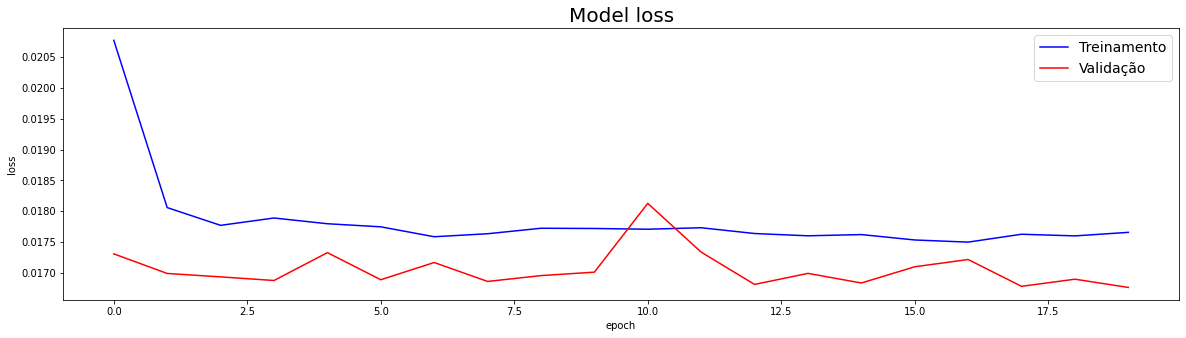

Treinamento: 13.30 RMSE
Teste: 9.69 RMSE

 Calcula R Regression
Treinamento: 0.95
Teste: 0.97

 Calcula R2
Treinamento: 0.91
Teste: 0.94
248/248 [==============================] - 1s 2ms/step - loss: 3.8552e-04 - mse: 3.8552e-04


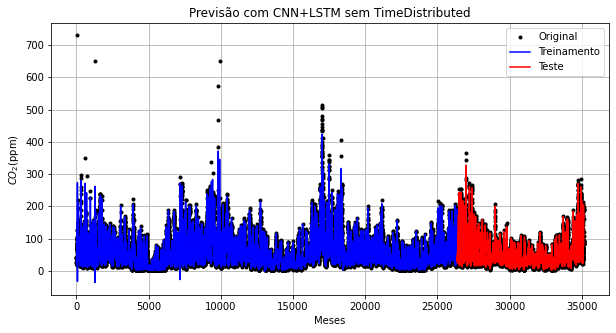

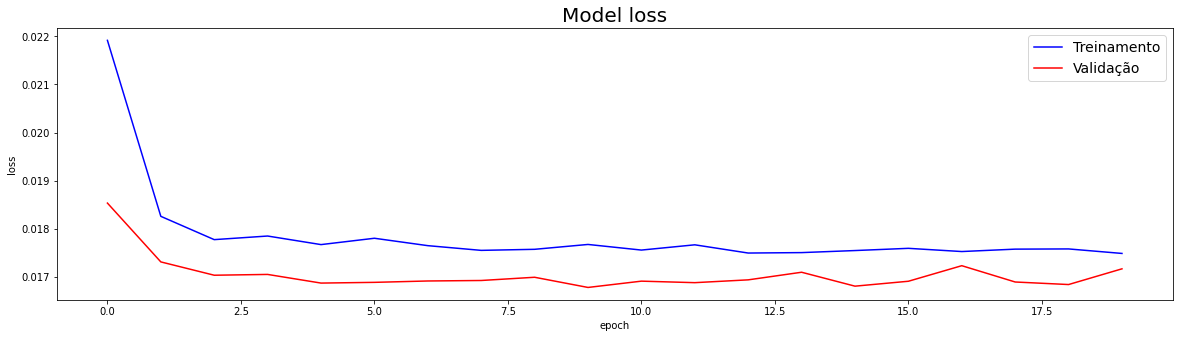

Treinamento: 13.51 RMSE
Teste: 10.05 RMSE

 Calcula R Regression
Treinamento: 0.95
Teste: 0.97

 Calcula R2
Treinamento: 0.90
Teste: 0.93


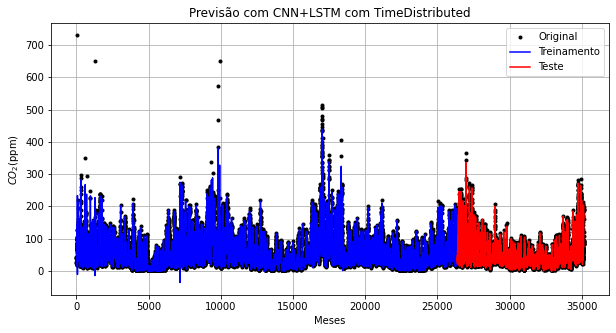

In [134]:
results_NN1DLSTMSemTD = modelLSTM.evaluate(trainX, trainY, verbose=1)
NN1DLSTMSemTDMetrics = plot_history_predictions(historySemTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMSemTD, 
                         'Previsão com CNN+LSTM sem TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)

results_NN1DLSTMTD = modelLSTM.evaluate(trainX, trainY, verbose=1)
NN1DLSTMTDMetrics = plot_history_predictions(historyTD, trainX_whole, trainY_whole, testX, testY, scaler, modelCNN1DLSTMTD, 
                         'Previsão com CNN+LSTM com TimeDistributed', 'Meses', '$CO_2$(ppm)', look_back)



# Dados

In [137]:
#MAE, MSE, NMSE, r, R2
#MLP,           []
#RNN simples,   [X]
#LSTM,          [X]
#GRU,           []
#CNN1D,         []
#FCN+LSTM e     []
#Conv2DLSTM     []

loss = {
  'GRU': results_gru[0], 
  'RNN': results_rnn[0], 
  'LSTM': results_lstm[0], 
  #'LSTM 2': results_lstm2[0],
  'CNN1D': results_cnn1d[0],
  'LSTM2D': results_lstm2d[0],
  'SEM TD': results_NN1DLSTMSemTD[0],
  'COM TD': results_NN1DLSTMTD[0],
}
mse = {
    'MLP': results_gru[1], 
    'RNN': results_rnn[1], 
    'LSTM': results_lstm[1], 
   # 'LSTM 2': results_lstm2[1],
   'CNN1D': results_cnn1d[1],
   'LSTM2D': results_lstm2d[1],
   'SEM TD': results_NN1DLSTMSemTD[1],
  'COM TD': results_NN1DLSTMTD[1],
}

nmse = {
    'GRU': GRUMetrics[0], 
    'RNN': RNNMetrics[0], 
    'LSTM': LSTMMetrics[0],  
    #'LSTM 2': LSTMMetrics2[0],
    'CNN1D': CNN1DMetrics[0],
    'LSTM2D': LSTM2DMetrics[0],
    'SEM TD': NN1DLSTMSemTDMetrics[0],
    'COM TD': NN1DLSTMTDMetrics[0],
}

r = {
    'GRU': GRUMetrics[1], 
    'RNN': RNNMetrics[1][0], 
    'LSTM': LSTMMetrics[1][0],
    # 'LSTM 2': LSTMMetrics2[1][0],
     'CNN1D': CNN1DMetrics[1],
     'LSTM2D': LSTM2DMetrics[1],
     'SEM TD': NN1DLSTMSemTDMetrics[1],
    'COM TD': NN1DLSTMTDMetrics[1],
}

R2 = {
    'GRU': GRUMetrics[2], 
    'RNN': RNNMetrics[2], 
    'LSTM': LSTMMetrics[2],
    #'LSTM 2': LSTMMetrics2[2],
    'CNN1D': CNN1DMetrics[2],
    'LSTM2D': LSTM2DMetrics[2],
    'SEM TD': NN1DLSTMSemTDMetrics[2],
    'COM TD': NN1DLSTMTDMetrics[2],
}

In [92]:
loss

{'LSTM': 0.009857634082436562, 'RNN': 0.009857634082436562}

# Conclusão

Para analisar e comparar os resultados obtidos, plotamos os graficos que compara os modelos pelas metricas:


* Loss: 
* MSE: 
* NMSE: 
* R: 
* R2:


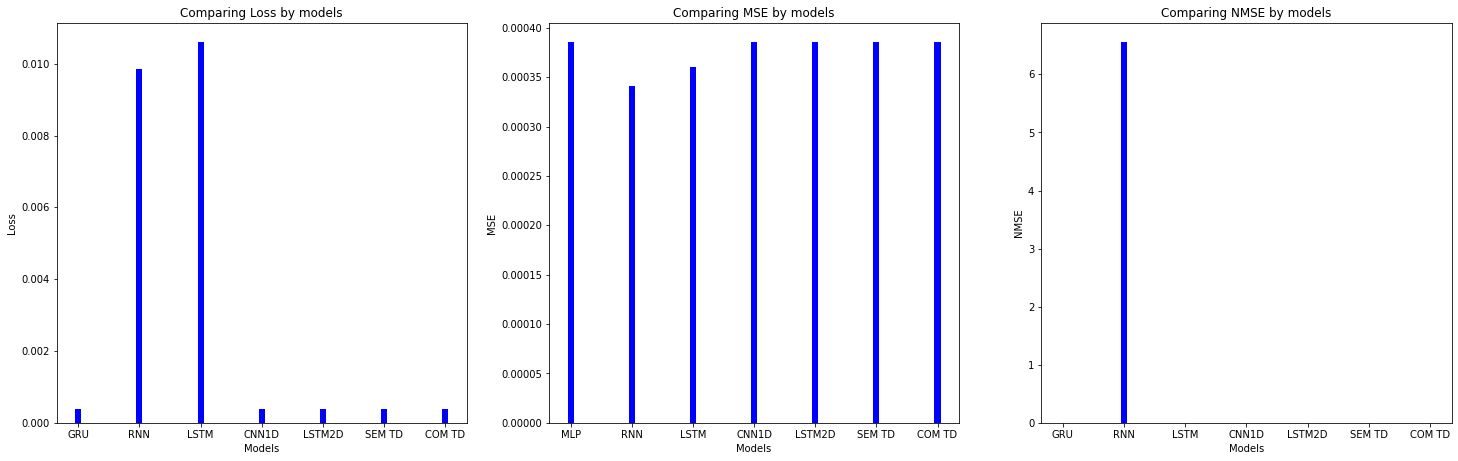

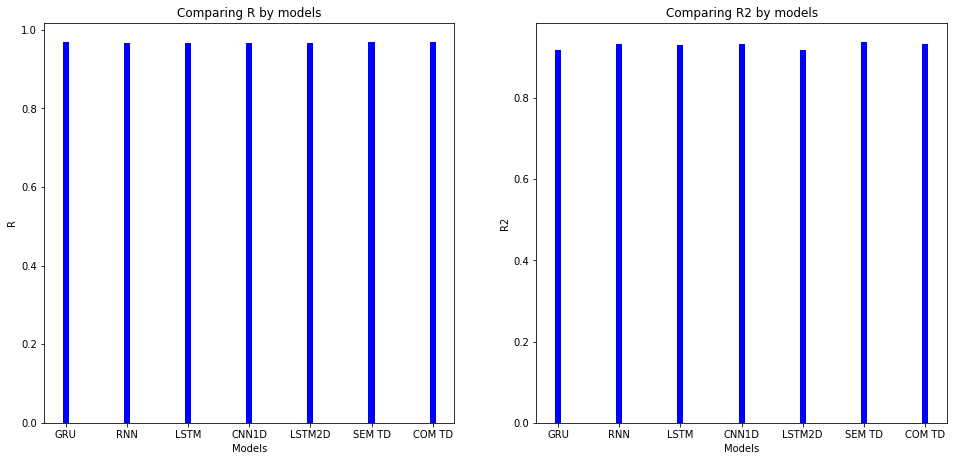

In [138]:
plt.figure(figsize=(25, 25))
plot_bar_graph(list(loss.keys()), list(loss.values()), "Loss", [3, 3, 1])
plot_bar_graph(list(mse.keys()), list(mse.values()), "MSE",  [3, 3, 2])
plot_bar_graph(list(nmse.keys()), list(nmse.values()), "NMSE",  [3, 3, 3])
plt.show()
plt.figure(figsize=(25, 25))
plot_bar_graph(list(r.keys()), list(r.values()), "R",  [3, 3, 1])
plot_bar_graph(list(R2.keys()), list(R2.values()), "R2",  [3, 3, 2])
#plot_bar_graph(list(fac2.keys()), list(fac2.values()), "Fac2",  [3, 3, 3])
plt.show()